# PDE-FIND za gravitacijski pad

Vinko Dragušica, 2022.

Predstavljen je kod koji pomoću modula PDE-FIND iz danih podataka otkriva jednadžbu koja opisuje dinamiku čestice koja pada pod utjecajem homogenog gravitacijskog polja za $g = 9.81$.
$$
u_{tt} = -g
$$

In [1]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import sys; sys.path.append('../')
from PDE_FIND_CM import *
import itertools

In [2]:
import pandas
df = pandas.read_csv('../Datasets/GravPad.csv', skiprows=1, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,100.0,99.987489,99.949954,99.887397,99.799816,99.687213,99.549587,99.386938,99.199265,98.98657,...,-1.342975,-3.607553,-5.897153,-8.211777,-10.551423,-12.916093,-15.305785,-17.7205,-20.160239,-22.625


In [3]:
u = df.to_numpy()
x = [0]
t = np.linspace(0,5,100)
dt = t[1]-t[0]
#dx = x[1]-x[0]

Text(0, 0.5, 'u(t)')

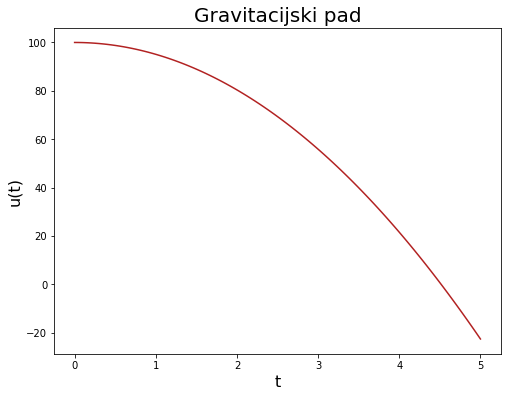

In [4]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,u[0,:],color='firebrick')
plt.title('Gravitacijski pad', fontsize = 20)
plt.xlabel('t', fontsize = 16)
plt.ylabel('u(t)', fontsize = 16)

## Konstruiramo $\Theta (U)$ i računamo $U_t$:

Konstruiramo funkcije koje će se nalaziti u $\Theta$. Također specificiramo njihove opise i na kraju pomoću build_Theta konstruiramo $\Theta$ koji ćemo koristiti kasnije. <br>
time_diff i space_diff izračunati su pomoću metode konačnih razlika (funkcija FiniteDiff()).

Ispisana je lista funkcija kandidata za PDJ. Svaka od ispisanih funkcija ekvivalentna je stupcu u $\Theta (U)$.

In [5]:
m = len(x)
n = len(t)

ut = np.zeros((m,n), dtype=np.complex64)
utt = np.zeros((m,n), dtype=np.complex64)
u2 = np.zeros((m,n), dtype=np.complex64)
u3 = np.zeros((m,n), dtype=np.complex64)

for i in range(m):
    ut[i,:] = FiniteDiff(u[i,:], dt, 1)
    utt[i,:] = FiniteDiff(u[i,:], dt,2) # koristi se kasnije kod funkcije TrainSTRidge
    u2[i,:] = u[i,:]**2
    u3[i,:] = u[i,:]**3
    
ut = np.reshape(ut, (n*m,1), order='F')
utt = np.reshape(utt, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)),ut])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F'),
                    np.reshape(u2, (n*m,1), order='F'),
                    np.reshape(u3, (n*m,1), order='F')])
derivatives_description = ['','u_{t}']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=1, data_description = ['u','u^2','u^3'])
descr

['', 'u_{t}', 'u^3', 'u^2', 'u', 'u^3u_{t}', 'u^2u_{t}', 'uu_{t}']

## Računamo $\xi$:

TrainSTRidge dijeli podatke na dio za trening (80% ukupnih podataka) i dio za validaciju (20% ukupnih podataka). Algoritam traži optimalnu vrijednost za varijablu tol (tolerancija ispod koje zanemarujemo varijablu) i odabire toleranciju provjerom na validacijskom skupu, uključujući i $\ell^0$ penalizaciju za $\xi$ u funkciji gubitka.

In [6]:
# Solve with STRidge
w = TrainSTRidge(X,utt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (-9.810000 +0.000000i)
    + (-0.000000 +0.000000i)u_{t}
    + (0.000000 +0.000000i)u^3
    + (-0.000000 +0.000000i)u^2
    + (0.000000 +0.000000i)u
    + (0.000000 +0.000000i)u^3u_{t}
    + (-0.000000 +0.000000i)u^2u_{t}
    + (0.000000 +0.000000i)uu_{t}
   


In [7]:
err = abs(np.array([(0)*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:\n")
print(np.mean(err), '%')
#print("Srednja greška parametara:", np.mean(err), '%')
#print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:

0.0 %
